<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week13/SOM_clustering_LVQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOM and clustering + LVQ

In [ ]:
# Re-import necessary libraries after code execution state reset
!pip install minisom --quiet

## Datasets

### Face

In [ ]:
import numpy as np

def generate_face_points(num_points=500):
    # Eyes
    eye1_center = np.array([-1.5, 0.6])
    eye2_center = np.array([1.5, 0.6])
    eye_radius = 0.15

    eye1 = np.random.multivariate_normal(eye1_center, eye_radius*np.eye(2), size=num_points//4)
    eye2 = np.random.multivariate_normal(eye2_center, eye_radius*np.eye(2), size=num_points//4)
    labels_eye1 = ['eye_left'] * len(eye1)
    labels_eye2 = ['eye_right'] * len(eye2)

    # Nose
    nose_center = np.array([0, -0.8])
    nose = np.random.multivariate_normal(nose_center, (eye_radius/4)*np.eye(2), size=num_points//8)
    labels_nose = ['nose'] * len(nose)

    # Mouth (parabola-like curve)
    mouth_length = 3.0
    mouth_theta = np.linspace(-np.pi/2, np.pi/2, num_points//2)
    mouth_x = mouth_theta
    mouth_y = mouth_length * (mouth_theta**2 * 0.25 - 1) + np.random.normal(0, 0.21, size=mouth_theta.shape)
    mouth = np.vstack((mouth_x, mouth_y)).T
    labels_mouth = ['mouth'] * len(mouth)

    # Combine
    points = np.vstack((eye1, eye2, mouth, nose))
    labels = labels_eye1 + labels_eye2 + labels_mouth + labels_nose

    return points, np.array(labels)



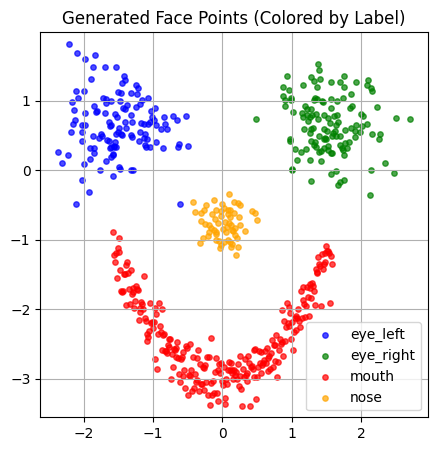

In [ ]:
points, labels = generate_face_points(500)

import matplotlib.pyplot as plt

# Define colors for each label
label_colors = {
    'eye_left': 'blue',
    'eye_right': 'green',
    'nose': 'orange',
    'mouth': 'red'
}

plt.figure(figsize=(5, 5))
for label in np.unique(labels):
    mask = labels == label
    plt.scatter(points[mask, 0], points[mask, 1],
                s=15, label=label, color=label_colors.get(label, 'gray'), alpha=0.7)

plt.title('Generated Face Points (Colored by Label)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


### Jin-Jang

(1124, 2)
(1124,)


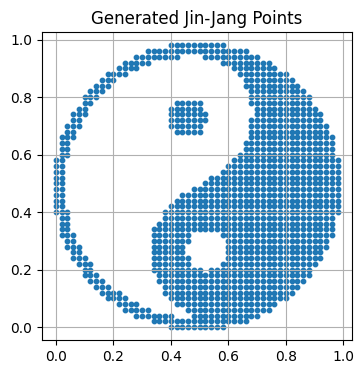

In [6]:
import numpy as np
from PIL import Image
def generate_jinjang():
    img = Image.open('jj1.bmp').convert('L')
    arr = np.array(img)
    i, j = np.where(arr < 122)
    T = np.vstack((i / arr.shape[0], j / arr.shape[1])).T
    np.random.seed(42)
    np.random.shuffle(T)
    data = T
    labels = np.array(['1'] * len(data))
    return data, labels


# download file from github:
import requests, io, os
image_folder = "images"
if not os.path.exists(image_folder):
    file_url = "https://raw.githubusercontent.com/reitezuz/18NES1-2025-/main/week13/jj1.bmp"
    response = requests.get(file_url)

    # save image to current folder:
    with open('./jj1.bmp', 'wb') as f:
        f.write(response.content)




points, labels = generate_jinjang()
print(points.shape)
print(labels.shape)

# plot:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(points[:,0], points[:,1], s=10)
plt.title('Generated Jin-Jang Points')
plt.axis('equal')
plt.grid(True)

## Chose the dataset
- jinjang - image example
- blobs1, blobs2 - simple 2D data
- face, moons, circle - harder examples
- iris - real-world data

Data shape: (400, 2) Labels shape: (400,)


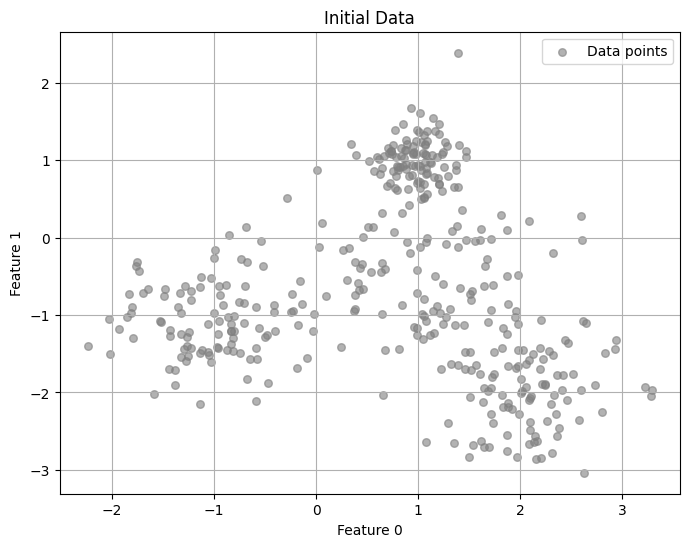

In [ ]:
# Choose dataset
dataset_choice = 'blobs2'  # options: 'blobs1', 'blobs2', 'face', 'moons', 'circles', 'iris', 'jinjang'

import numpy as np
from sklearn.datasets import make_blobs, make_circles, make_moons, load_iris
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def get_dataset(dataset_choice):
    if dataset_choice == 'blobs1':
        data, labels = make_blobs(n_samples=300, centers=[[1,1], [-1,-1], [2,-2]], cluster_std=[0.75, 0.5, 0.5], random_state=42)
        #data, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=42)
    elif dataset_choice == 'blobs2':
        data, labels = make_blobs(n_samples=400, centers=[[1,1], [1,-0.5], [-1,-1], [2,-2]], cluster_std=[0.25, 0.75, 0.5, 0.5], random_state=42)

    elif dataset_choice == 'face':
        data, labels = generate_face_points()
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    elif dataset_choice == 'moons':
        data, labels = make_moons(n_samples=300, noise=0.1, random_state=42)

    elif dataset_choice == 'circles':
        data, labels = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)

    elif dataset_choice == 'iris':
        iris = load_iris()
        data = iris.data
        labels = iris.target
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    elif dataset_choice == 'jinjang':
        data, labels = generate_jinjang()
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
    else:
        raise ValueError("Unknown dataset choice.")
    return data, labels

data, labels = get_dataset(dataset_choice)
print(f'Data shape: {data.shape} Labels shape: {labels.shape}')



# Choose dimensions to plot (in case of higher dimensional data)
dims = (0, 1)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(data[:, dims[0]], data[:, dims[1]], c='gray', s=30, alpha=0.6, label='Data points')
plt.xlabel(f'Feature {dims[0]}')
plt.ylabel(f'Feature {dims[1]}')
plt.title('Initial Data')
plt.legend()
plt.grid(True)
plt.show()

## Train SOM:

In [ ]:
from minisom import MiniSom
from collections import defaultdict

# Initialize and train SOM
#som_shape = (16, 15)
som_shape = (6, 6)

# parameters:
learning_rate = 0.8
epochs = 1000
sigma = 1.0

som = MiniSom(
    x=som_shape[0],         # number of neurons along the x-axis (width of the SOM grid)
    y=som_shape[1],         # number of neurons along the y-axis (height of the SOM grid)
    input_len=data.shape[1],            # dimensionality of the input data (number of features)
    sigma=sigma,            # spread of the neighborhood function (controls how far the influence of the BMU reaches)
    learning_rate=learning_rate,      # initial learning rate (decreases over time)
    neighborhood_function='gaussian',  # function for neighborhood influence ('gaussian', 'mexican_hat', 'bubble', 'triangle')
    activation_distance='euclidean',   # distance metric for BMU search ('euclidean', 'cosine', etc.)
    topology='rectangular',  # topology of the map grid ('rectangular' or 'hexagonal')
    random_seed=879          # random seed for reproducibility (optional)
)
som.random_weights_init(data)
som.train_random(data, epochs)

def compute_bmu_positions(som, data):
    bmu_positions = defaultdict(list)
    for i, x in enumerate(data):
        bmu = som.winner(x) # Best Matching Unit for each pattern
        bmu_positions[bmu].append(labels[i])  # Group labels by BMU position
    return bmu_positions
# Create a dictionary to store which labels fall into each SOM neuron (BMU)
bmu_positions = compute_bmu_positions(som, data)



## Quantization and topographic errors:

In [ ]:
# Calculate SOM quantization and topographic error

# Quantization error (average distance to BMU)
def quantization_error(som, data):
    return np.mean([np.linalg.norm(x - som.get_weights()[som.winner(x)]) for x in data])

# Topographic error (how often 2nd BMU is not adjacent to the BMU)
def topographic_error(som, data):
    errors = 0
    for x in data:
        bmu = som.winner(x)
        dists = np.linalg.norm(som.get_weights() - x, axis=2)
        flat = dists.reshape(-1)
        closest = np.argsort(flat)[:2]  # indices of 2 closest neurons
        coords = [np.unravel_index(i, dists.shape) for i in closest]
        if not are_adjacent(coords[0], coords[1]):
            errors += 1
    return errors / len(data)

def are_adjacent(c1, c2):
    dx = abs(c1[0] - c2[0])
    dy = abs(c1[1] - c2[1])
    return (dx <= 1 and dy <= 1) and not (dx == 0 and dy == 0)

qe = quantization_error(som, data)
te = topographic_error(som, data)
print(f"Quantization Error: {qe:.4f}")
print(f"Topographic Error: {te:.4f}")

Quantization Error: 0.2156
Topographic Error: 0.0375


## Visualizations:


### Weight planes

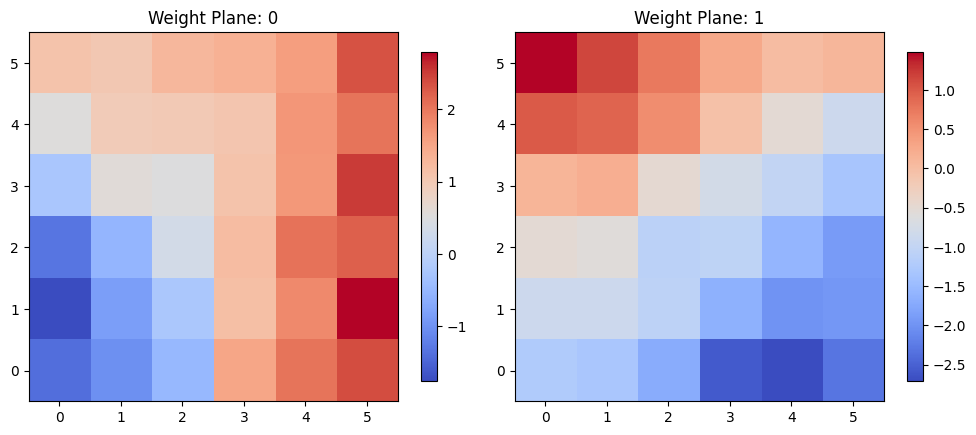

In [ ]:
import matplotlib.pyplot as plt

def plot_weight_planes(som, feature_names):
    """
    Plot one weight plane per input feature.
    """
    weights = som.get_weights()  # shape: (x, y, features)
    n_features = weights.shape[2]
    fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

    if n_features == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        im = ax.imshow(weights[:, :, i].T, cmap='coolwarm', origin='lower')
        ax.set_title(f'Weight Plane: {feature_names[i]}')
        fig.colorbar(im, ax=ax, shrink=0.7)

    plt.tight_layout()
    plt.show()

feature_names = list(range(data.shape[1]))
plot_weight_planes(som, feature_names)

### U-matrix (Unified Distance Matrix)

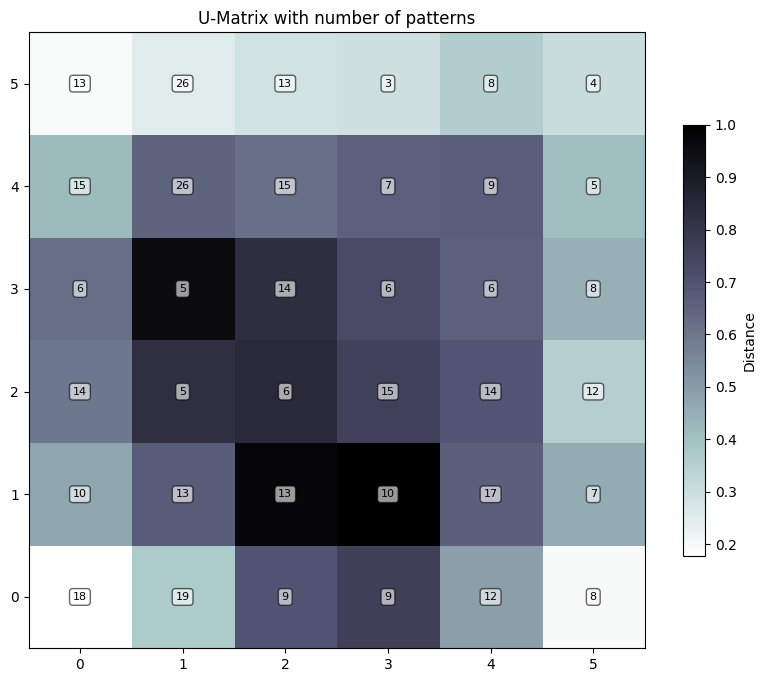

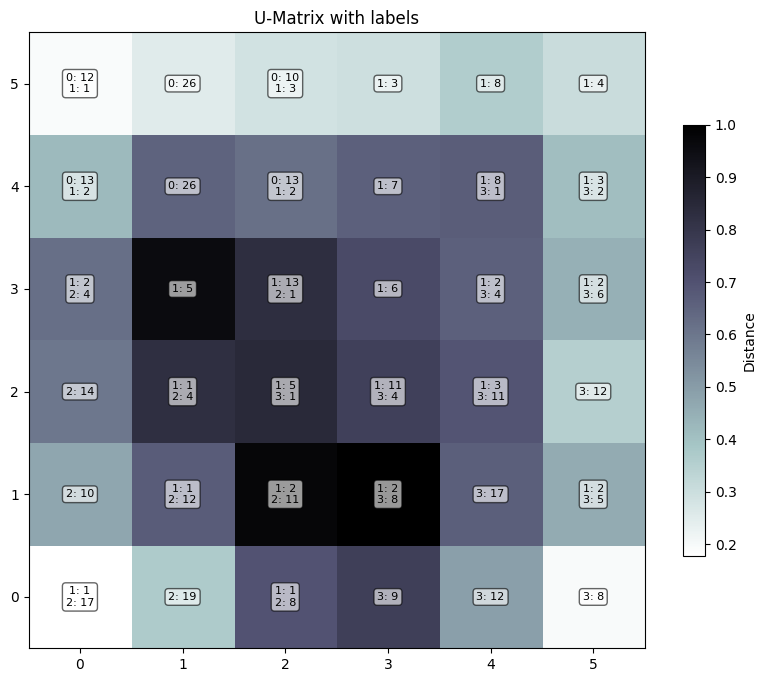

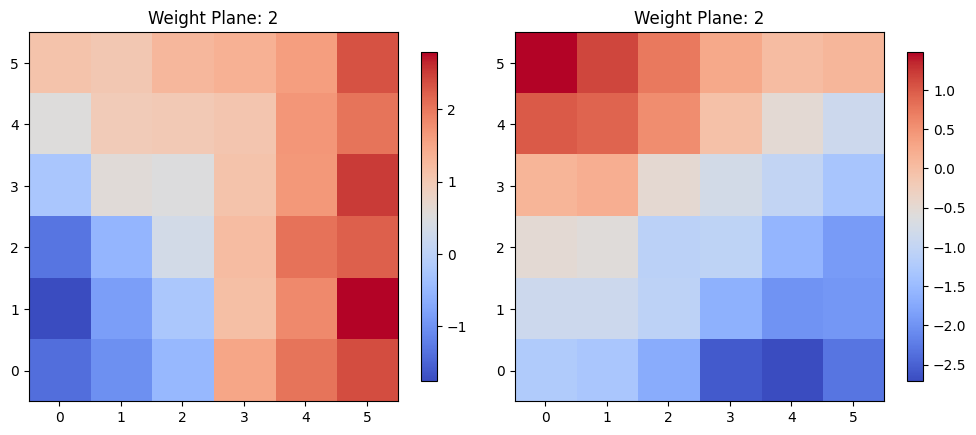

In [ ]:
def plot_U_matrix(som, bmu_positions):
    # Plot the U-matrix (Unified Distance Matrix
    umat = som.distance_map().T  # transpose for correct orientation
    plt.figure(figsize=(10, 8))
    plt.imshow(umat, cmap='bone_r', origin='lower')  # U-matrix as heatmap
    plt.colorbar(label='Distance', shrink = 0.7)     # Color scale showing distance between neighboring neurons

    # Plot size of clusters at their BMU positions
    for (x, y), names in bmu_positions.items():
        label = f"{len(names)}"
        plt.text(x, y, label, ha='center', va='center', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

    plt.title("U-Matrix with number of patterns")
    plt.grid(False)
    plt.show()

def plot_U_matrix_by_class(som, bmu_positions):
    # Plot the U-matrix (Unified Distance Matrix
    umat = som.distance_map().T  # transpose for correct orientation
    plt.figure(figsize=(10, 8))
    plt.imshow(umat, cmap='bone_r', origin='lower')  # U-matrix as heatmap
    plt.colorbar(label='Distance', shrink = 0.7)     # Color scale showing distance between neighboring neurons

    # Plot size of clusters at their BMU positions
    for (x, y), names in bmu_positions.items():
        label = "\n".join(f"{name}: {names.count(name)}" for name in set(names))
        plt.text(x, y, label, ha='center', va='center', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

    plt.title("U-Matrix with labels")
    plt.grid(False)
    plt.show()


def get_cluster_labels(som, bmu_positions):
    result_dict = {}
    for (x, y), names in bmu_positions.items():
        d = {name: names.count(name) for name in set(names)}
        winner = max(d, key=d.get)
        result_dict[(x, y)] = winner
    return result_dict



# Plot the U-matrix (Unified Distance Matrix)
plot_U_matrix(som, bmu_positions)
plot_U_matrix_by_class(som, bmu_positions)
plot_weight_planes(som, labels)
bmu_labels = get_cluster_labels(som, bmu_positions)


In [ ]:
# Get winner coordinates for each pattern
bmu_coords = np.array([som.winner(x) for x in data])

# Convert coordinates to 1D cluster IDs
cluster_ids = [int(x * som_shape[1] + y) for x, y in bmu_coords]

# Group labels by cluster
from collections import defaultdict
clusters = defaultdict(list)
for i, cid in enumerate(cluster_ids):
    clusters[cid].append(labels[i])

# Print grouped labels
for cid, ls in sorted(clusters.items()):
    lbls = set(ls)
    a = { int(x) : ls.count(x) for x in lbls }
    print(f"Representant {cid:2}: {len(ls):3}  {a}")


Representant  0:  18  {1: 1, 2: 17}
Representant  1:  10  {2: 10}
Representant  2:  14  {2: 14}
Representant  3:   6  {1: 2, 2: 4}
Representant  4:  15  {0: 13, 1: 2}
Representant  5:  13  {0: 12, 1: 1}
Representant  6:  19  {2: 19}
Representant  7:  13  {1: 1, 2: 12}
Representant  8:   5  {1: 1, 2: 4}
Representant  9:   5  {1: 5}
Representant 10:  26  {0: 26}
Representant 11:  26  {0: 26}
Representant 12:   9  {1: 1, 2: 8}
Representant 13:  13  {1: 2, 2: 11}
Representant 14:   6  {1: 5, 3: 1}
Representant 15:  14  {1: 13, 2: 1}
Representant 16:  15  {0: 13, 1: 2}
Representant 17:  13  {0: 10, 1: 3}
Representant 18:   9  {3: 9}
Representant 19:  10  {1: 2, 3: 8}
Representant 20:  15  {1: 11, 3: 4}
Representant 21:   6  {1: 6}
Representant 22:   7  {1: 7}
Representant 23:   3  {1: 3}
Representant 24:  12  {3: 12}
Representant 25:  17  {3: 17}
Representant 26:  14  {1: 3, 3: 11}
Representant 27:   6  {1: 2, 3: 4}
Representant 28:   9  {1: 8, 3: 1}
Representant 29:   8  {1: 8}
Representan

### U-matrix 3D Surface

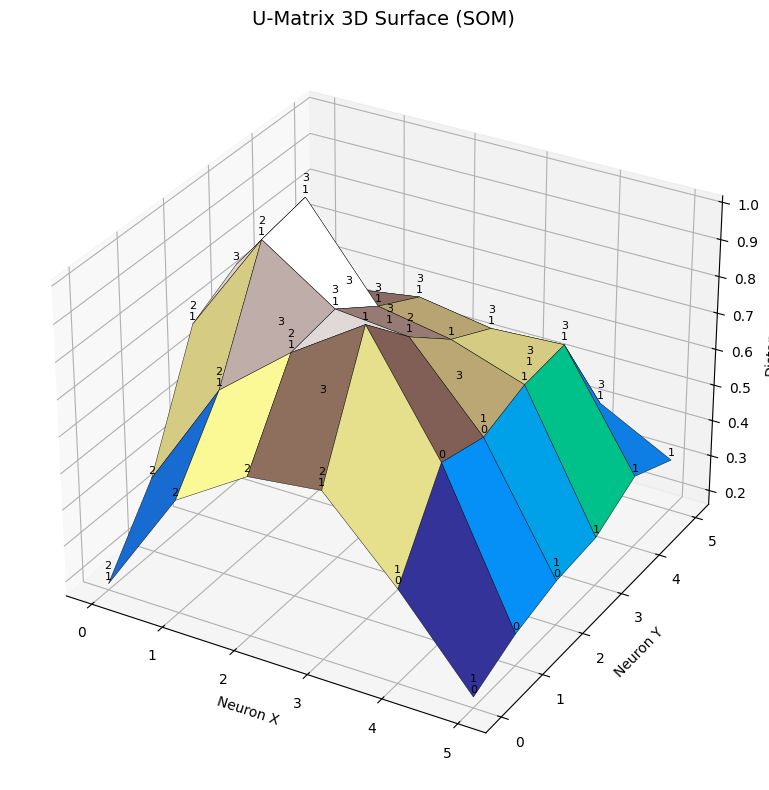

In [ ]:

# Plot the enhanced U-matrix

# --- 3D U-Matrix Visualization ---
from mpl_toolkits.mplot3d import Axes3D


def plot_U_matrix_3D(som, data_scaled, labels):
    u_matrix = som.distance_map()  # shape: (x, y)
    x_len, y_len = u_matrix.shape
    X, Y = np.meshgrid(np.arange(y_len), np.arange(x_len))  # Note: match order

    # Get BMUs for labeling
    bmu_positions = defaultdict(list)
    for i, x in enumerate(data_scaled):
        bmu = som.winner(x)
        bmu_positions[bmu].append(labels[i])

    # 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, u_matrix, cmap='terrain', edgecolor='k', linewidth=0.3, antialiased=True)

    # Plot labels slightly above surface
    for (i, j), names in bmu_positions.items():
        for k, name in enumerate(set(names)):
            z = u_matrix[i, j] + 0.02 + k * 0.03
            ax.text(j, i, z, name, fontsize=8, ha='center', va='center')

    ax.set_title('U-Matrix 3D Surface (SOM)', fontsize=14)
    ax.set_xlabel("Neuron X")
    ax.set_ylabel("Neuron Y")
    ax.set_zlabel("Distance")
    plt.tight_layout()
    plt.show()



plot_U_matrix_3D(som, data, labels)


### Enhanced U-Matrix with Directional Distances

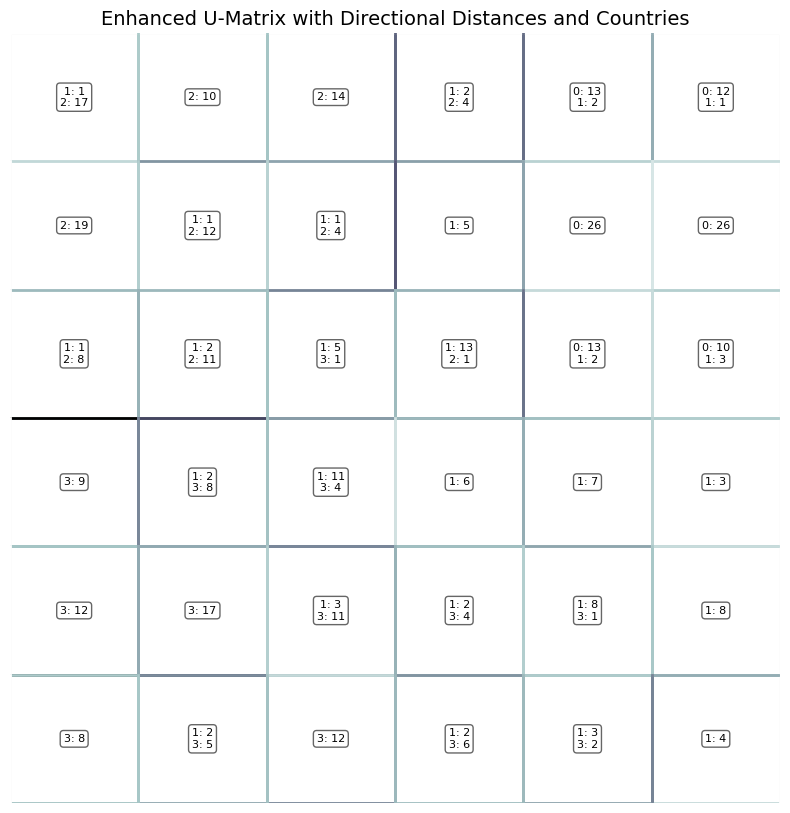

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
from collections import defaultdict
from numpy.linalg import norm

# Compute directional distances for each neuron: [top, right, bottom, left]
weights = som.get_weights()
umatrix = np.zeros((som_shape[0], som_shape[1], 4))  # shape: (rows, cols, 4 directions)
max_dist = 0


for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        w = weights[i, j]
        if i > 0:  # top
            d = norm(w - weights[i - 1, j])
            umatrix[i, j, 0] = d
            max_dist = max(max_dist, d)
        if j < som_shape[1] - 1:  # right
            d = norm(w - weights[i, j + 1])
            umatrix[i, j, 1] = d
            max_dist = max(max_dist, d)
        if i < som_shape[0] - 1:  # bottom
            d = norm(w - weights[i + 1, j])
            umatrix[i, j, 2] = d
            max_dist = max(max_dist, d)
        if j > 0:  # left
            d = norm(w - weights[i, j - 1])
            umatrix[i, j, 3] = d
            max_dist = max(max_dist, d)

# Group countries by their BMU positions
bmu_positions = defaultdict(list)
for i, x in enumerate(data):
    bmu = som.winner(x)
    bmu_positions[bmu].append(labels[i])

# --- Enhanced U-Matrix with directional distances ---
fig, ax = plt.subplots(figsize=(10, 10))

# Color mapping helper (clip values to [0, 1])
def safe_cmap(val):
    return cm.bone_r(np.clip(val, 0.0, 1.0))

norm_factor = max_dist if max_dist > 0 else 1e-10

for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        x, y = j, i
        # Normalize directional distances (linear scale)
        top = umatrix[i-1, j, 0] / norm_factor if i > 0 else 0
        right = umatrix[i, j, 1] / norm_factor
        bottom = umatrix[i-1, j, 2] / norm_factor if i > 0 else 0
        left = umatrix[i, j, 3] / norm_factor


        # Draw neuron square
        ax.add_patch(Rectangle((x, y), 1, 1, facecolor='white', edgecolor='gray'))

        # Draw colored edges
        ax.plot([x, x + 1], [y + 1, y + 1], color=safe_cmap(top), linewidth=2)     # top
        ax.plot([x + 1, x + 1], [y, y + 1], color=safe_cmap(right), linewidth=2)   # right
        ax.plot([x, x + 1], [y, y], color=safe_cmap(bottom), linewidth=2)          # bottom
        ax.plot([x, x], [y, y + 1], color=safe_cmap(left), linewidth=2)            # left

# Add country names stacked vertically
    # Plot country names at their BMU positions
for (y, x), names in bmu_positions.items():
    label = "\n".join(f'{x}: {names.count(x)}' for x in set(names))
    plt.text(x + 0.5, y + 0.5, label, ha='center', va='center', fontsize=8,
              bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))

# Layout and appearance
ax.set_xlim(0, som_shape[1])
ax.set_ylim(som_shape[0], 0)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Enhanced U-Matrix with Directional Distances and Countries", fontsize=14)
plt.show()


###  Plot the SOM in the projection into the input space
- change the axes (index_0, index_1)

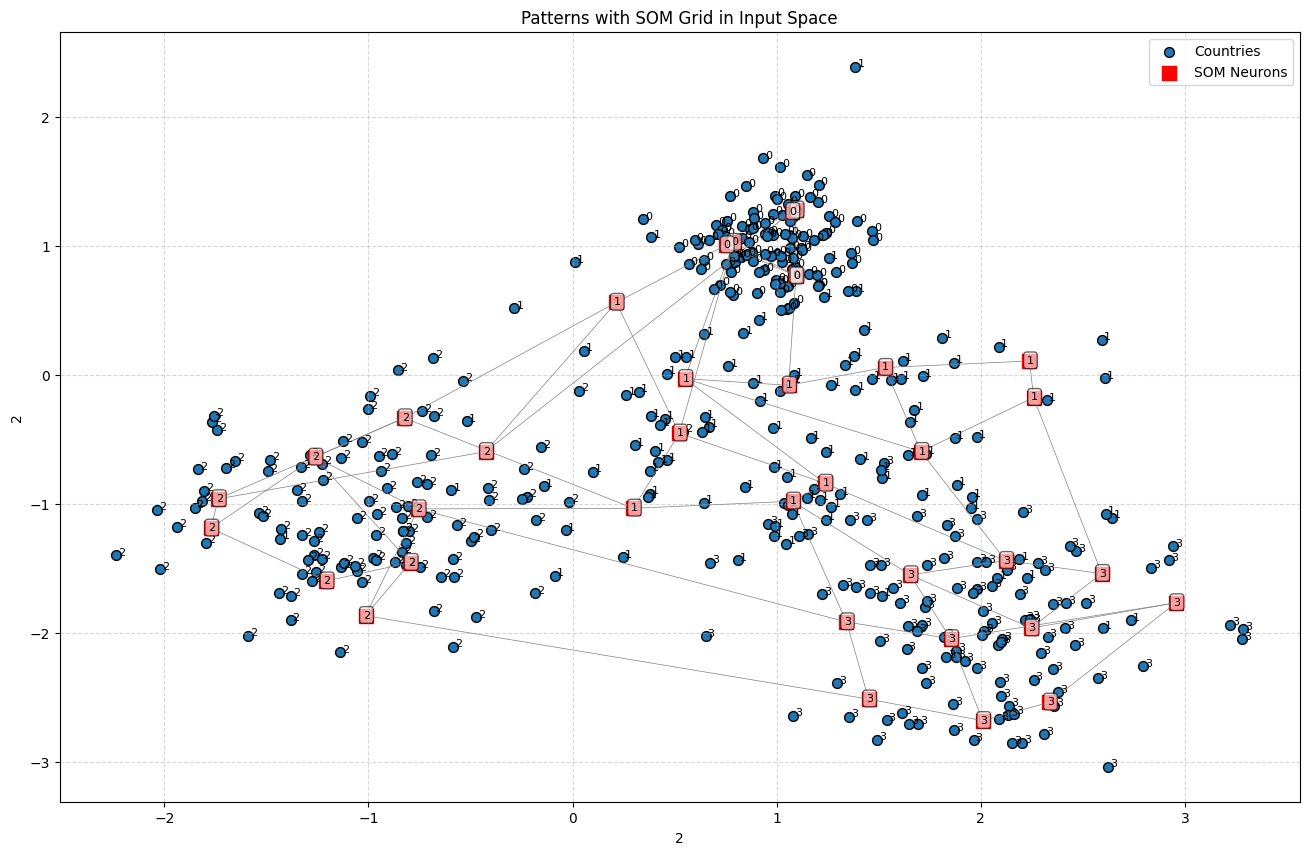

In [ ]:
index_0 = 0
index_1 = 1

def plot_patterns_in_input_space(som, data, labels, bmu_labels, index_0, index_1):
      plt.figure(figsize=(16, 10))

      # Plot data points
      plt.scatter(data[:, index_0], data[:, index_1], s=50, edgecolor='k', label='Countries')

      # Add pattern labels
      for i, name in enumerate(labels):
          plt.text(data[i, index_0] + 0.01, data[i, index_1], name, fontsize=8)

      # Plot SOM neuron weights (i.e., grid in input space)
      weights = som.get_weights().reshape(-1, data.shape[1])  # (num_neurons, 2)
      plt.scatter(weights[:, index_0], weights[:, index_1], marker='s', s=100, c='red', label='SOM Neurons')

      # Add bmu labels
      for (x, y), label in bmu_labels.items():
              plt.text(som.get_weights()[x, y][0] + 0.005, som.get_weights()[x, y][1] + 0.005, label, ha='center', va='center', fontsize=8,
              bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))


      # Optionally: connect neurons in a grid (lines)
      for i in range(som_shape[0]):
          for j in range(som_shape[1] - 1):
              w1 = som.get_weights()[i, j]
              w2 = som.get_weights()[i, j + 1]
              plt.plot([w1[index_0], w2[index_0]], [w1[index_1], w2[index_1]], 'gray', linewidth=0.5)
      for j in range(som_shape[1]):
          for i in range(som_shape[0] - 1):
              w1 = som.get_weights()[i, j]
              w2 = som.get_weights()[i + 1, j]
              plt.plot([w1[index_0], w2[index_0]], [w1[index_1], w2[index_1]], 'gray', linewidth=0.5)

      plt.title("Patterns with SOM Grid in Input Space")
      plt.xlabel(labels[index_0])
      plt.ylabel(labels[index_1])
      plt.grid(True, linestyle='--', alpha=0.5)
      plt.legend()
      plt.show()

plot_patterns_in_input_space(som, data, labels, bmu_labels, index_0, index_1)

# LVQ

In [ ]:
def train_lvq(data, labels, som, n_epochs=10, learning_rate=0.3, version='lvq1', window=0.3, epsilon=0.5):
    """
    Fine-tune SOM weights using LVQ variants.

    Parameters:
        data           : array of shape (n_samples, n_features)
        labels         : array of shape (n_samples,)
        som            : trained MiniSom object
        n_epochs       : number of passes over the dataset
        learning_rate  : initial learning rate
        version        : 'lvq1', 'lvq2.1', or 'lvq3'
        window         : window width for LVQ2.1 and LVQ3
        epsilon        : LVQ3 learning adjustment factor
    """
    label_map = {}
    for x, label in zip(data, labels):
        bmu = som.winner(x)
        label_map[bmu] = label_map.get(bmu, []) + [label]

    # Assign most frequent label to each neuron
    neuron_labels = {}
    for bmu, votes in label_map.items():
        neuron_labels[bmu] = max(set(votes), key=votes.count)

    weights = som.get_weights()
    alpha = learning_rate

    for epoch in range(n_epochs):
        for x, label in zip(data, labels):
            dists = np.linalg.norm(weights - x, axis=2)
            bmu_idx = np.unravel_index(np.argmin(dists), dists.shape)
            bmu_weight = weights[bmu_idx]

            bmu_label = neuron_labels.get(bmu_idx)

            if version.lower() == 'lvq1':
                if bmu_label == label:
                    weights[bmu_idx] += alpha * (x - bmu_weight)
                else:
                    weights[bmu_idx] -= alpha * (x - bmu_weight)

            elif version.lower() in ('lvq2.1', 'lvq3'):
                # Find second BMU
                flat_weights = weights.reshape(-1, x.shape[0])
                dists_flat = np.linalg.norm(flat_weights - x, axis=1)
                sorted_indices = np.argsort(dists_flat)
                bmu1_idx_flat = sorted_indices[0]
                bmu2_idx_flat = sorted_indices[1]

                bmu1 = np.unravel_index(bmu1_idx_flat, weights.shape[:2])
                bmu2 = np.unravel_index(bmu2_idx_flat, weights.shape[:2])

                w1 = weights[bmu1]
                w2 = weights[bmu2]

                d1 = np.linalg.norm(x - w1)
                d2 = np.linalg.norm(x - w2)

                r = min(d1, d2) / max(d1, d2)
                if abs(d1 - d2) / (d1 + d2) < window:
                    l1 = neuron_labels.get(bmu1)
                    l2 = neuron_labels.get(bmu2)

                    if version.lower() == 'lvq2.1':
                        if (l1 == label and l2 != label):
                            weights[bmu1] += alpha * (x - w1)
                            weights[bmu2] -= alpha * (x - w2)
                        elif (l2 == label and l1 != label):
                            weights[bmu1] -= alpha * (x - w1)
                            weights[bmu2] += alpha * (x - w2)

                    elif version.lower() == 'lvq3':
                        if l1 == label and l2 == label:
                            weights[bmu1] += epsilon * alpha * (x - w1)
                            weights[bmu2] += epsilon * alpha * (x - w2)
                        elif (l1 == label and l2 != label):
                            weights[bmu1] += alpha * (x - w1)
                            weights[bmu2] -= alpha * (x - w2)
                        elif (l2 == label and l1 != label):
                            weights[bmu1] -= alpha * (x - w1)
                            weights[bmu2] += alpha * (x - w2)

        alpha *= 0.95  # decay learning rate


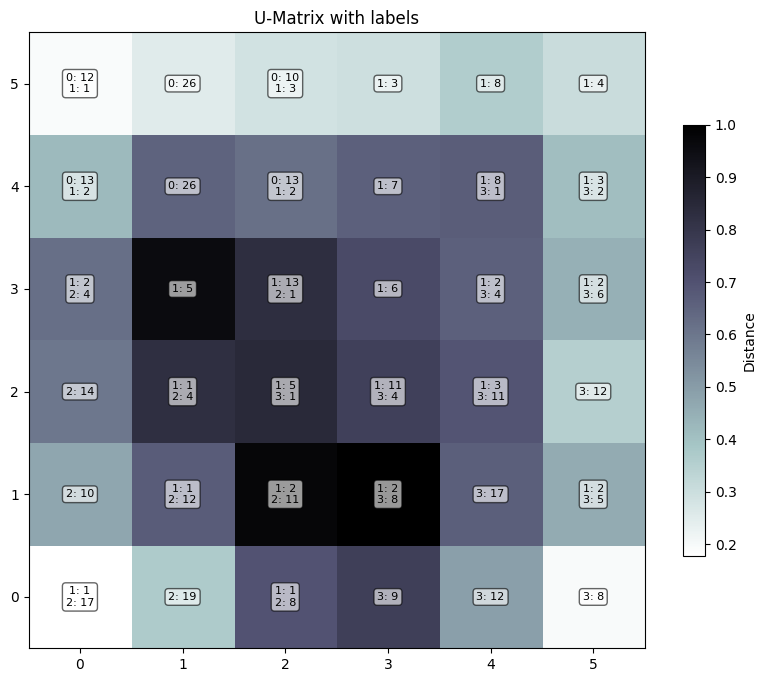

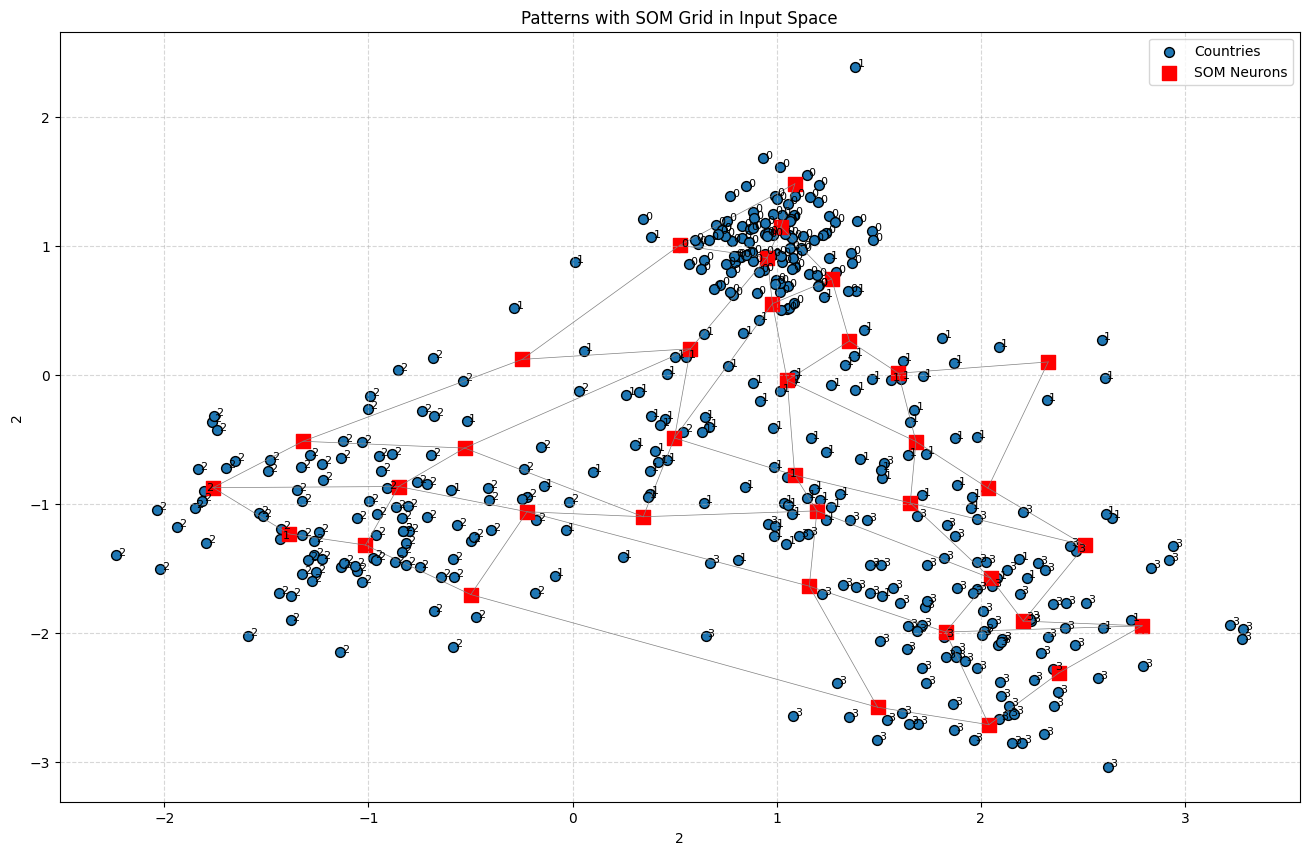

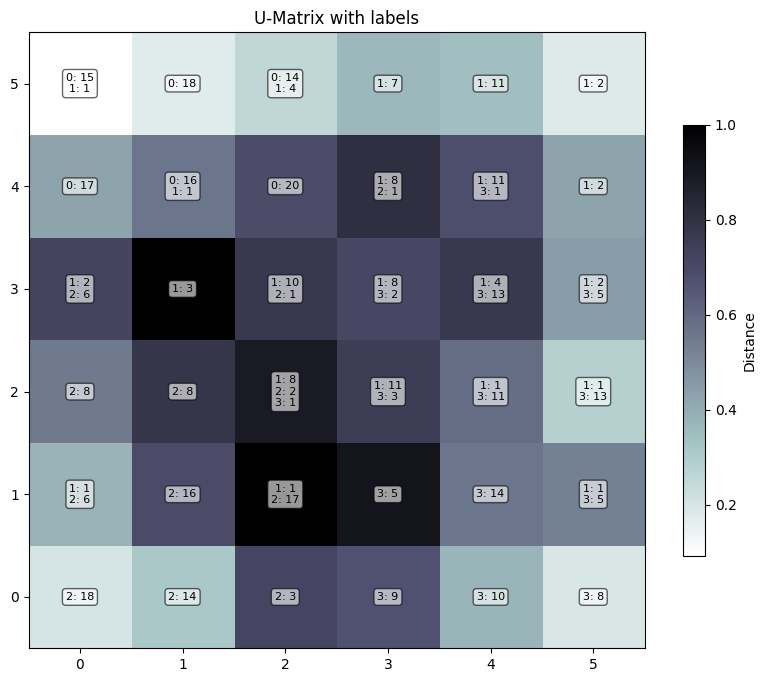

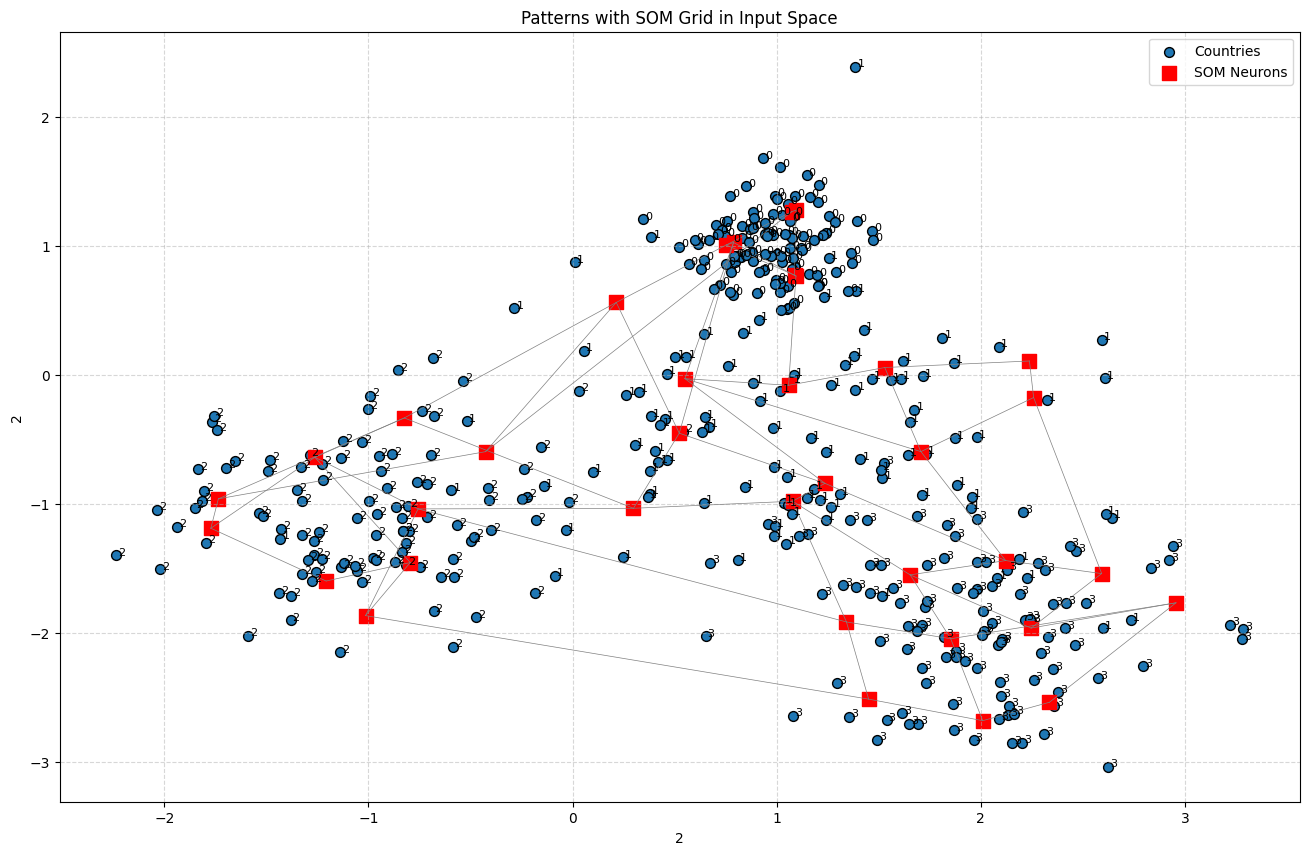

In [ ]:

plot_U_matrix_by_class(som, bmu_positions)
plot_patterns_in_input_space(som, data, labels, index_0, index_1)
train_lvq(data, labels, som, n_epochs=10, learning_rate=0.3, version='lvq1')
train_lvq(data, labels, som, n_epochs=10, learning_rate=0.3, version='lvq2.1')
train_lvq(data, labels, som, n_epochs=10, learning_rate=0.3, version='lvq3')
bmu_positions_new = compute_bmu_positions(som, data)

plot_U_matrix_by_class(som, bmu_positions_new)
plot_patterns_in_input_space(som, data, labels, index_0, index_1)

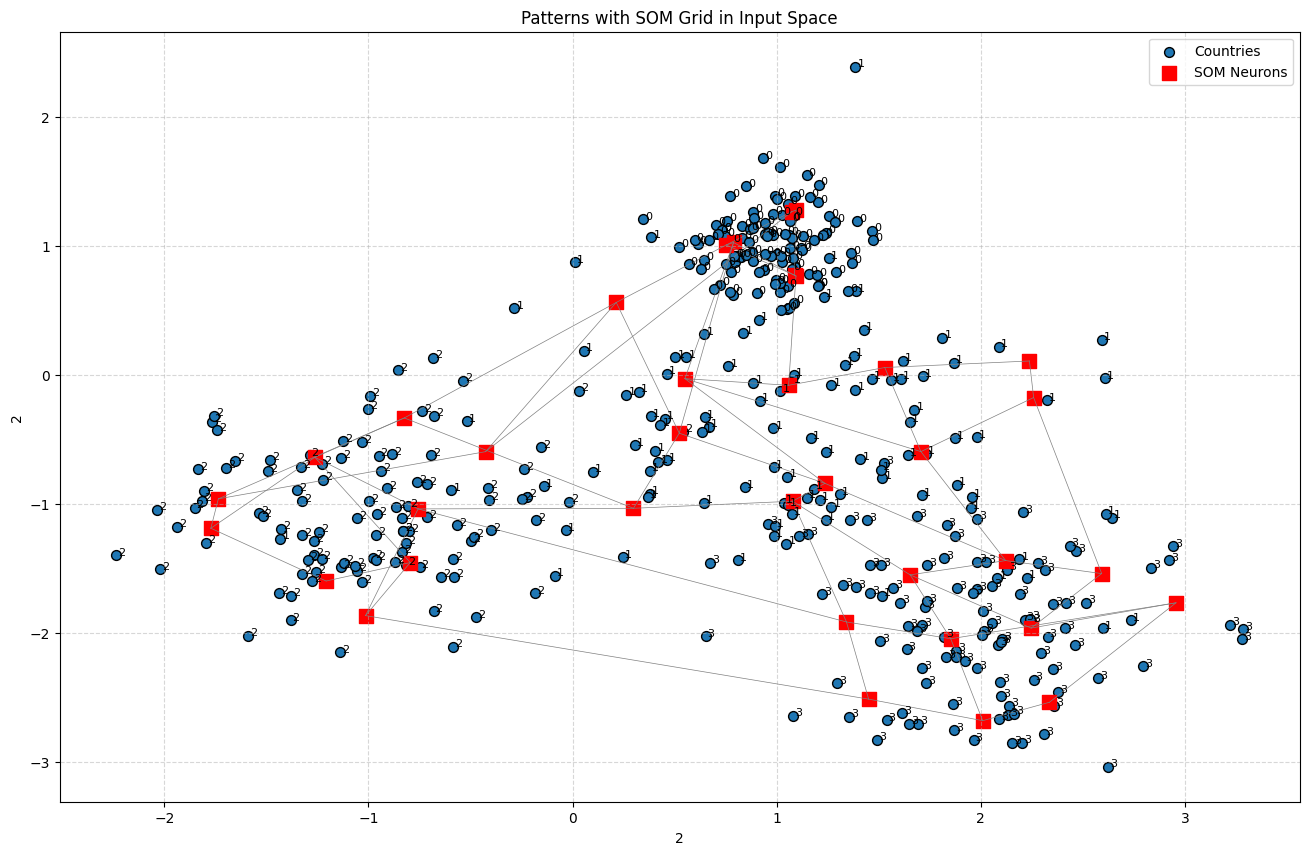

In [ ]:
index_0 = 0
index_1 = 1
plt.figure(figsize=(16, 10))

# Plot data points
plt.scatter(data[:, index_0], data[:, index_1], s=50, edgecolor='k', label='Countries')

# Add country names
for i, name in enumerate(labels):
    plt.text(data[i, index_0] + 0.01, data[i, index_1], name, fontsize=8)

# Plot SOM neuron weights (i.e., grid in input space)
weights = som.get_weights().reshape(-1, data.shape[1])  # (num_neurons, 2)
plt.scatter(weights[:, index_0], weights[:, index_1], marker='s', s=100, c='red', label='SOM Neurons')

# Optionally: connect neurons in a grid (lines)
for i in range(som_shape[0]):
    for j in range(som_shape[1] - 1):
        w1 = som.get_weights()[i, j]
        w2 = som.get_weights()[i, j + 1]
        plt.plot([w1[index_0], w2[index_0]], [w1[index_1], w2[index_1]], 'gray', linewidth=0.5)
for j in range(som_shape[1]):
    for i in range(som_shape[0] - 1):
        w1 = som.get_weights()[i, j]
        w2 = som.get_weights()[i + 1, j]
        plt.plot([w1[index_0], w2[index_0]], [w1[index_1], w2[index_1]], 'gray', linewidth=0.5)

plt.title("Patterns with SOM Grid in Input Space")
plt.xlabel(labels[index_0])
plt.ylabel(labels[index_1])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()